# U-Net Model for RV Segmentation

## Training U-Net CNN

In [1]:
import sys
sys.path.append("..")
import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src import data,unet

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import utils

train_dir = "/home/ubuntu/project/trainingdata/TrainingSet"
#train_dir = "/Users/aksharkumar/Documents/mlndCapstone/trainingdata/TrainingSet"

images=[]
inner_masks=[]
outer_masks = []

patient_directories = sorted(glob.glob(os.path.join(train_dir, "patient*")))

for patient_dir in patient_directories:
    imgdata = data.ImageData(patient_dir)
    images += imgdata.labeled_images
    inner_masks += imgdata.endo_masks
    outer_masks += imgdata.epi_masks

images = np.asarray(images)[:,:,:,None].astype('float64')
i_masks = np.asarray(inner_masks)
o_masks = np.asarray(outer_masks)

dims = i_masks.shape
classes = len(set(i_masks[0].flatten()))
new_shape = dims + (classes,)
i_masks = utils.to_categorical(i_masks).reshape(new_shape)
o_masks = utils.to_categorical(o_masks).reshape(new_shape)

def normalize(x, epsilon=1e-7, axis=(1,2)):
    x -= np.mean(x, axis=axis, keepdims=True)
    x /= np.std(x, axis=axis, keepdims=True) + epsilon
    
normalize(images,axis=(1,2))

print("There are %d total training images." % len(images))
print("There are %d total inner masks." % len(inner_masks))
print("There are %d total outer masks." % len(outer_masks))


There are 243 total training images.
There are 243 total inner masks.
There are 243 total outer masks.


In [9]:
height,width,_ = images[0].shape
dropout = 0.0

unet_conv = unet.UNet()

model = unet_conv.get_unet(height=height,width=width,channels=1,features=32,steps=3,dropout=dropout,padding='same')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 216, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 216, 256, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 216, 256, 32) 0           activation_15[0][0]              
__________________________________________________________________________________________________
conv2d_17 

In [10]:
from keras.optimizers import Adam
from keras import backend as K

def dice_coef(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    intersection = K.sum(flat_y_true * flat_y_pred)
    return (2. * intersection + 1.) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + 1.)

def dice_coef_np(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (np.sum(y_true) + np.sum(y_pred) + 1.)


def weighted_categorical_crossentropy(y_true, y_pred, weights=[0.1,0.9], epsilon=1e-8):
    ndim = K.ndim(y_pred)
    ncategory = K.int_shape(y_pred)[-1]
    # scale predictions so class probabilities of each pixel sum to 1
    y_pred /= K.sum(y_pred, axis=(ndim-1), keepdims=True)
    y_pred = K.clip(y_pred, epsilon, 1-epsilon)
    w = K.constant(weights) * (ncategory / sum(weights))
    # first, average over all axis except classes
    cross_entropies = -K.mean(y_true * K.log(y_pred), axis=tuple(range(ndim-1)))
    return K.sum(w * cross_entropies)


def show_plots(history):    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
#sgd = optimizers.SGD(lr=0.01, momentum=0.99)
model.compile(optimizer=Adam(lr=1e-3),loss=[weighted_categorical_crossentropy],metrics=[dice_coef])

In [11]:
#TODO: 1. split data into training and validation set
#      2. Augment the data
#      3. Train model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from math import ceil

seed = 53

validation_split=0.2

epochs = 20
batch_size = 32


split_index = int((1 - validation_split) * len(images))

train_steps = ceil(split_index / batch_size)
val_steps = ceil((len(images)-split_index )/batch_size)

train_images = images[:split_index]
train_inner_masks = i_masks[:split_index]

validation_images = images[split_index:]
validation_inner_masks = i_masks[split_index:]


data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.01,
                     fill_mode='nearest')

train_images_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**data_gen_args)


#seed = 1
#height,width,channels = train_images[0].shape
#print(train_images[0].shape)
#print(train_inner_masks[0].shape)
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_inner_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_inner_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)




/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:748: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [12]:
checkpointer = ModelCheckpoint(filepath='saved_models/endo_models/weights-20epochs-nodrop.hdf5', verbose=1, save_best_only=True)

hist = model.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer],
                   validation_data=(validation_images,validation_inner_masks),validation_steps=val_steps)
#show_plots(hist)

Epoch 1/20
7/7 [==============================] - 214s 31s/step - loss: 0.1651 - dice_coef: 0.5877 - val_loss: 0.1884 - val_dice_coef: 0.9186

Epoch 00001: val_loss improved from inf to 0.18836, saving model to saved_models/endo_models/weights-20epochs-nodrop.hdf5
Epoch 2/20
7/7 [==============================] - 213s 30s/step - loss: 0.1372 - dice_coef: 0.7660 - val_loss: 0.1110 - val_dice_coef: 0.7386

Epoch 00002: val_loss improved from 0.18836 to 0.11101, saving model to saved_models/endo_models/weights-20epochs-nodrop.hdf5
Epoch 3/20
7/7 [==============================] - 212s 30s/step - loss: 0.1150 - dice_coef: 0.7684 - val_loss: 0.1068 - val_dice_coef: 0.7985

Epoch 00003: val_loss improved from 0.11101 to 0.10677, saving model to saved_models/endo_models/weights-20epochs-nodrop.hdf5
Epoch 4/20
7/7 [==============================] - 212s 30s/step - loss: 0.1187 - dice_coef: 0.8068 - val_loss: 0.1070 - val_dice_coef: 0.8014

Epoch 00004: val_loss did not improve
Epoch 5/20
7/7 [

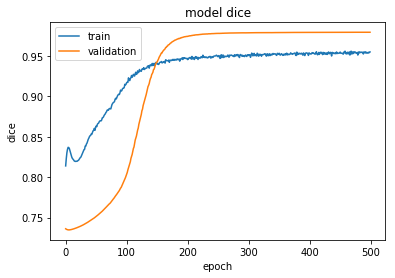

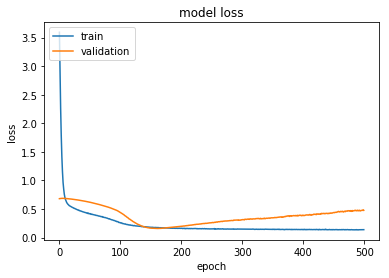

In [7]:
#print(np.max(hist.history['val_dice_coef']))
#print(np.max(hist.history['dice_coef']))

# model.load_weights('saved_models/weights.hdf5')
show_plots(hist)


250 Epochs, 0.5 Dropout


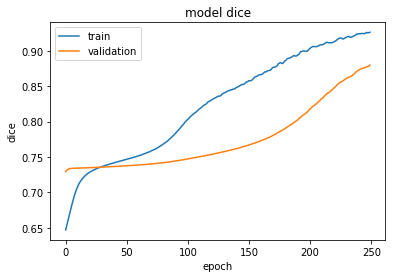

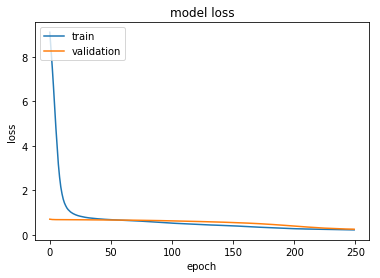

In [27]:
print("250 Epochs, 0.5 Dropout")
show_plots(hist)

300 Epochs, no dropout


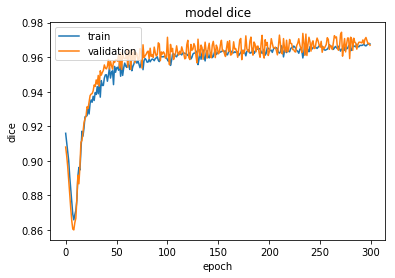

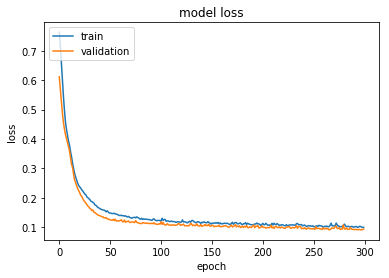

In [9]:
print("300 Epochs, no dropout")
show_plots(hist)

250 Epochs, no dropout


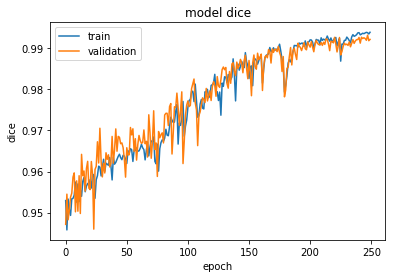

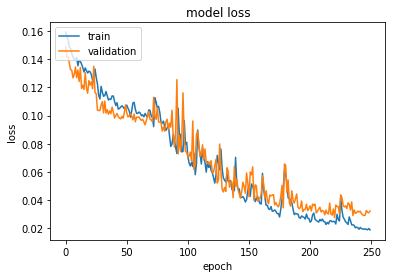

In [12]:
print("250 Epochs, no dropout")
show_plots(hist)

In [14]:
import tensorflow as tf

model.load_weights('saved_models/endo_models/weightsNoDrop.hdf5')
def calculate_dice(images, masks_true):
    dices = []
   # image = images[0]
    #mask_pred = model.predict(image[None,:,:,:])
    #print(mask_pred.shape)
    #mask_true = masks_true[0]
    #dims = mask_true.shape
    #mask_pred_re = utils.to_categorical(mask_pred).reshape(dims)
    #print(mask_true.shape)
    #print(mask_pred_re.shape)
    #y_true = mask_true.astype('float64')
    #y_pred = mask_pred[0,:,:,:].astype('float64')
    
    #print(y_true.shape)
    #print(y_true.flatten().shape)
    #print(y_pred.shape)
    #print(y_pred.flatten().shape)
    #print(K.flatten(y_true))
    #print(K.flatten(y_pred))
    #dice = dice_coef(y_true.flatten(),y_pred.flatten())
    #for image,mask_true in zip(images,masks_true):
     #   mask_pred = model.predict(image[None,:,:,:])
      #  y_true = mask_true[:,:,1].astype('float64')
       # y_pred = mask_pred[:,:,1].astype('float64')
        #dices.append(dice_coef(y_true,y_pred))
    
    masks_pred = np.concatenate([model.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true.astype('float64')
        y_pred = mask_pred.astype('float64')
        dices.append(dice_coef(y_true.flatten(), y_pred.flatten()))
    #print(dices)
    #dice_tf = K.constant(dices,dtype='float64')
    #print(masks_pred)
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))
    #print(dice)
print("Training Statistics(No Dropout)...")
calculate_dice(train_images,train_inner_masks)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images,validation_inner_masks)


Training Statistics(No Dropout)...
Dice Average: 0.76 Dice Stdev: 0.02
Validation Statistics(No Dropout)...
Dice Average: 0.76 Dice Stdev: 0.02


# Results of Endocardium Model

## Training
hyperparams: {Dropout:0.5, Epochs:50, Batch Size: 20}

- train_dice = 0.62365097794
- val_dice = 0.522672422078

hyperparams: {Dropout:0.5, Epochs: 200, Batch Size: 20}

- train_dice = 0.878794970879
- val_dice = 0.841971736781

hyperparams: {Dropout:0.0, Epochs:200, Batch Size: 20}
- train_dice = 0.91 +/- 0.03
- val_dice = 0.92 +/- 0.02


In [6]:
model_epi = unet_conv.get_unet(height=height,width=width,channels=1,features=32,steps=3,dropout=dropout,padding='same')

model_epi.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 216, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 216, 256, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 216, 256, 32) 0           activation_15[0][0]              
__________________________________________________________________________________________________
conv2d_17 

In [7]:
seed_epi = 10

train_outer_masks = o_masks[:split_index]

train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_outer_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_outer_masks, y=None, seed=seed)


train_outer_generator = zip(train_images_generator, train_masks_generator)

validation_outer_masks = o_masks[split_index:]
model_epi.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=[dice_coef])

/Users/aksharkumar/miniconda2/envs/rvenv/lib/python3.6/site-packages/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/Users/aksharkumar/miniconda2/envs/rvenv/lib/python3.6/site-packages/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [11]:

checkpointer = ModelCheckpoint(filepath='saved_models/epi_models/weightsNoDrop.hdf5',verbose=1,save_best_only=True)

hist_epi = model_epi.fit_generator(train_outer_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=2,callbacks=[checkpointer],
                                 validation_data=(validation_images,validation_outer_masks),validation_steps=val_steps)

Epoch 1/200
Epoch 00000: val_loss improved from inf to 0.69272, saving model to saved_models/epi_models/weightsNoDrop.hdf5
17s - loss: 0.7114 - dice_coef: 0.4918 - val_loss: 0.6927 - val_dice_coef: 0.5005
Epoch 2/200
Epoch 00001: val_loss improved from 0.69272 to 0.67302, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.6831 - dice_coef: 0.5055 - val_loss: 0.6730 - val_dice_coef: 0.5106
Epoch 3/200
Epoch 00002: val_loss improved from 0.67302 to 0.63828, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.6564 - dice_coef: 0.5199 - val_loss: 0.6383 - val_dice_coef: 0.5298
Epoch 4/200
Epoch 00003: val_loss improved from 0.63828 to 0.56203, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.6017 - dice_coef: 0.5529 - val_loss: 0.5620 - val_dice_coef: 0.5782
Epoch 5/200
Epoch 00004: val_loss improved from 0.56203 to 0.44360, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.4909 - dice_coef: 0.6352 - 

Epoch 00041: val_loss improved from 0.21776 to 0.21727, saving model to saved_models/epi_models/weightsNoDrop.hdf5
14s - loss: 0.2240 - dice_coef: 0.8644 - val_loss: 0.2173 - val_dice_coef: 0.8753
Epoch 43/200
Epoch 00042: val_loss did not improve
15s - loss: 0.2223 - dice_coef: 0.8653 - val_loss: 0.2179 - val_dice_coef: 0.8787
Epoch 44/200
Epoch 00043: val_loss improved from 0.21727 to 0.21656, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.2155 - dice_coef: 0.8734 - val_loss: 0.2166 - val_dice_coef: 0.8738
Epoch 45/200
Epoch 00044: val_loss did not improve
14s - loss: 0.2279 - dice_coef: 0.8646 - val_loss: 0.2176 - val_dice_coef: 0.8647
Epoch 46/200
Epoch 00045: val_loss did not improve
15s - loss: 0.2122 - dice_coef: 0.8738 - val_loss: 0.2176 - val_dice_coef: 0.8703
Epoch 47/200
Epoch 00046: val_loss did not improve
14s - loss: 0.2273 - dice_coef: 0.8650 - val_loss: 0.2167 - val_dice_coef: 0.8684
Epoch 48/200
Epoch 00047: val_loss improved from 0.21656 to 0

Epoch 00093: val_loss did not improve
14s - loss: 0.1746 - dice_coef: 0.8956 - val_loss: 0.1924 - val_dice_coef: 0.8854
Epoch 95/200
Epoch 00094: val_loss did not improve
15s - loss: 0.1857 - dice_coef: 0.8942 - val_loss: 0.1921 - val_dice_coef: 0.8841
Epoch 96/200
Epoch 00095: val_loss did not improve
14s - loss: 0.1833 - dice_coef: 0.8889 - val_loss: 0.1910 - val_dice_coef: 0.8827
Epoch 97/200
Epoch 00096: val_loss improved from 0.18983 to 0.18977, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - loss: 0.1837 - dice_coef: 0.8899 - val_loss: 0.1898 - val_dice_coef: 0.8849
Epoch 98/200
Epoch 00097: val_loss did not improve
14s - loss: 0.1748 - dice_coef: 0.8965 - val_loss: 0.1932 - val_dice_coef: 0.8744
Epoch 99/200
Epoch 00098: val_loss did not improve
15s - loss: 0.1802 - dice_coef: 0.8953 - val_loss: 0.1899 - val_dice_coef: 0.8885
Epoch 100/200
Epoch 00099: val_loss improved from 0.18977 to 0.18926, saving model to saved_models/epi_models/weightsNoDrop.hdf5
15s - los

Epoch 00147: val_loss did not improve
15s - loss: 0.1876 - dice_coef: 0.8849 - val_loss: 0.1887 - val_dice_coef: 0.8745
Epoch 149/200
Epoch 00148: val_loss did not improve
15s - loss: 0.1808 - dice_coef: 0.8922 - val_loss: 0.1897 - val_dice_coef: 0.8748
Epoch 150/200
Epoch 00149: val_loss did not improve
14s - loss: 0.1869 - dice_coef: 0.8861 - val_loss: 0.1866 - val_dice_coef: 0.9015
Epoch 151/200
Epoch 00150: val_loss did not improve
15s - loss: 0.1749 - dice_coef: 0.8925 - val_loss: 0.1848 - val_dice_coef: 0.8984
Epoch 152/200
Epoch 00151: val_loss did not improve
14s - loss: 0.1950 - dice_coef: 0.8738 - val_loss: 0.1835 - val_dice_coef: 0.8878
Epoch 153/200
Epoch 00152: val_loss did not improve
15s - loss: 0.1864 - dice_coef: 0.8921 - val_loss: 0.1917 - val_dice_coef: 0.8696
Epoch 154/200
Epoch 00153: val_loss did not improve
14s - loss: 0.1773 - dice_coef: 0.8915 - val_loss: 0.1819 - val_dice_coef: 0.8911
Epoch 155/200
Epoch 00154: val_loss did not improve
15s - loss: 0.1770 - dic

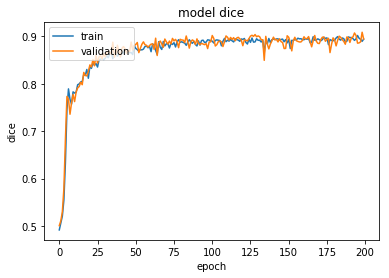

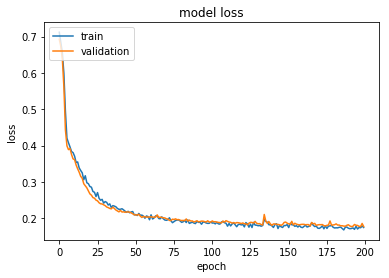

In [12]:
show_plots(hist_epi)

In [53]:
model_epi.load_weights('saved_models/epi_models/weightsNoDrop.hdf5')

print("Epicardium Model Results")
print("========================")
print("Training Statistics(No Dropout)...")
calculate_dice(train_images,train_outer_masks)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images,validation_outer_masks)

Epicardium Model Results
Training Statistics(No Dropout)...
Dice Average: 0.90 Dice Stdev: 0.03
Validation Statistics(No Dropout)...
Dice Average: 0.91 Dice Stdev: 0.03


In [20]:
model.load_weights('saved_models/endo_models/weights-500Epoch-50Drop.hdf5')
print("Training Statistics(500 Epochs, 0.5 Dropout)...")
calculate_dice(train_images,train_inner_masks)
print("Validation Statistics(500 Epochs, 0.5 Dropout)...")
calculate_dice(validation_images,validation_inner_masks)


Training Statistics(500 Epochs, 0.5 Dropout)...
Dice Average: 0.91 Dice Stdev: 0.03
Validation Statistics(500 Epochs, 0.5 Dropout)...
Dice Average: 0.93 Dice Stdev: 0.03


In [13]:
model.load_weights('saved_models/endo_models/weights-300Epochs-NoDrop.hdf5')
print("Training Statistics(300 Epochs, No Dropout)...")
calculate_dice(train_images,train_inner_masks)
print("Validation Statistics(300 Epochs, No Dropout)...")
calculate_dice(validation_images,validation_inner_masks)

Training Statistics(300 Epochs, No Dropout)...
Dice Average: 0.94 Dice Stdev: 0.03
Validation Statistics(300 Epochs, No Dropout)...
Dice Average: 0.94 Dice Stdev: 0.03


In [15]:
model.load_weights('saved_models/endo_models/weights-250Epochs-NoDrop.hdf5')
print("Training Statistics(250 Epochs, No Dropout)...")
calculate_dice(train_images,train_inner_masks)
print("Validation Statistics(250 Epochs, No Dropout)...")
calculate_dice(validation_images,validation_inner_masks)

Training Statistics(250 Epochs, No Dropout)...
Dice Average: 0.92 Dice Stdev: 0.03
Validation Statistics(250 Epochs, No Dropout)...
Dice Average: 0.92 Dice Stdev: 0.02


# View Predictions on training

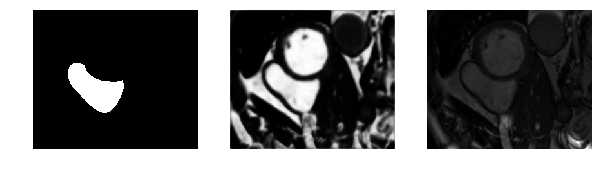

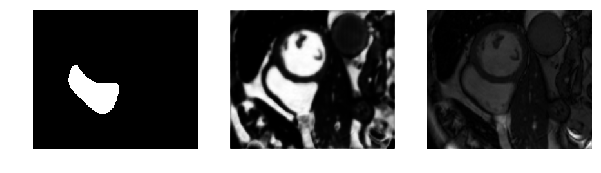

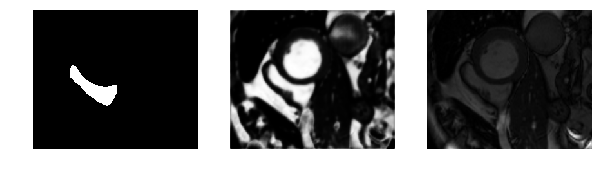

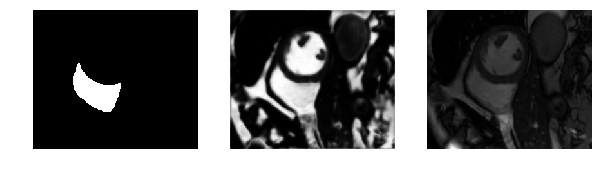

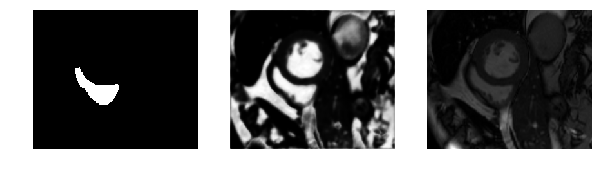

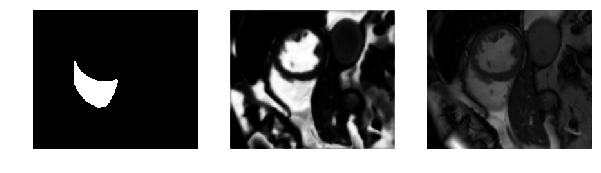

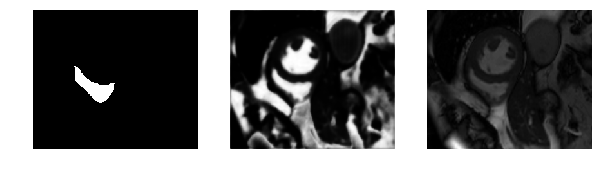

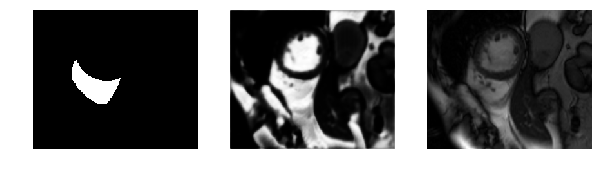

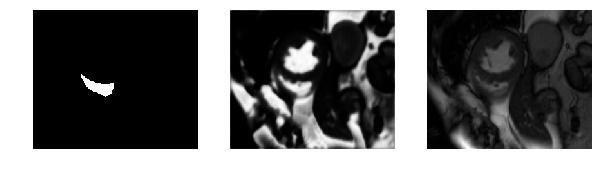

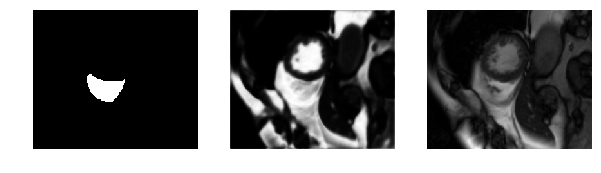

In [13]:
model.load_weights('saved_models/endo_models/weights-20epochs-nodrop.hdf5')

def show_masks(images, i_masks_true):
    masks_pred = np.concatenate([model.predict(image[None,:,:,:]) for image in images])
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        #print(mask.shape)
        #print(image.shape)
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(mask_pred[:,:,1],cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        
show_masks(images[:10], inner_masks[:10])